In [110]:
%run -m ipy_startup
%run -m ipy_logging false
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling import data_broker as dbm
from ml.api import trainer as ml_trainer

In [72]:
# Load data from data_modeling/prep/tcga-prep.ipynb
d = db.load_obj(src.TCGA_v1, db.PREP, 'raw-data-matrices')
d.keys()

dict_keys(['gene-copy-number', 'gene-rppa', 'gene-methylation', 'gene-rna-seq', 'gene-exome-seq', 'gene-expression'])

In [73]:
cohort = 'brca'

In [74]:
def prep(df, dt):
    df = df.loc[cohort]
    df.columns = pd.MultiIndex.from_tuples([(dt, c) for c in df])
    return df
df = pd.concat([prep(df, dt) for dt, df in d.items()], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, TCGA-3C-AAAU-01 to TCGA-Z7-A8R6-01
Columns: 90637 entries, (gene-copy-number, A1BG) to (gene-expression, ZZZ3)
dtypes: float64(90637)
memory usage: 764.1+ MB


In [75]:
df.head()

gene-copy-number                                             \
                            A1BG A1CF  A2M A2ML1 A2MP1 A3GALT2 A4GALT A4GNT   
TCGA-3C-AAAU-01              0.0 -1.0  1.0   1.0   1.0     0.0   -1.0   1.0   
TCGA-3C-AALI-01              0.0 -1.0  0.0   0.0   0.0    -1.0   -1.0   1.0   
TCGA-3C-AALJ-01              0.0  0.0  0.0   0.0   0.0    -1.0   -1.0  -1.0   
TCGA-3C-AALK-01              0.0  0.0  0.0   0.0   0.0     0.0    0.0   0.0   
TCGA-4H-AAAK-01              1.0  0.0 -1.0  -1.0  -1.0     0.0    0.0   0.0   

                          ...  gene-expression                              \
                AAAS AACS ...            ZUFSP ZW10 ZWINT ZXDB ZXDC ZYG11A   
TCGA-3C-AAAU-01 -1.0 -1.0 ...              NaN  NaN   NaN  NaN  NaN    NaN   
TCGA-3C-AALI-01  0.0  0.0 ...              NaN  NaN   NaN  NaN  NaN    NaN   
TCGA-3C-AALJ-01 -1.0  1.0 ...              NaN  NaN   NaN  NaN  NaN    NaN   
TCGA-3C-AALK-01  0.0  0.0 ...              NaN  NaN   NaN  NaN  NaN    NaN   
TCGA-4H-AAAK-01  0.0  0.0 ...              NaN  NaN   NaN  NaN  NaN    NaN   

                                       
                ZYG11B ZYX ZZEF1 ZZZ3  
TCGA-3C-AAAU-01    NaN NaN   NaN  NaN  
TCGA-3C-AALI-01    NaN NaN   NaN  NaN  
TCGA-3C-AALJ-01    NaN NaN   NaN  NaN  
TCGA-3C-AALK-01    NaN NaN   NaN  NaN  
TCGA-4H-AAAK-01    NaN NaN   NaN  NaN  

[5 rows x 90637 columns]

In [76]:
len(df)

1105

In [77]:
X = df[[dtyp.GENE_RNA_SEQ, dtyp.GENE_RPPA]].dropna(how='all', axis=1).dropna(how='all', axis=0)
m1 = X[dtyp.GENE_RNA_SEQ].isnull().all(axis=1)
m2 = X[dtyp.GENE_RPPA].isnull().all(axis=1)
X = X[(~m1) & (~m2)]
X, Y = X[dtyp.GENE_RNA_SEQ], X[dtyp.GENE_RPPA]
Y = Y.iloc[:,:10]
X = X.iloc[:,:100]

In [78]:
X.shape, Y.shape

((840, 100), (840, 10))

In [79]:
Y.columns.tolist()

['ABL1',
 'ACACA',
 'ACVRL1',
 'ADAR',
 'AKT1',
 'AKT2',
 'AKT3',
 'ANXA1',
 'ANXA7',
 'AR']

In [80]:
import imp
imp.reload(ml_trainer)

<module 'ml.api.trainer' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/trainer.py'>

In [93]:
from mgds.data_modeling.constants import SEED
from sklearn.linear_model import MultiTaskLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from IPython.core.debugger import Tracer


clfs = {
    'lasso': Pipeline([
        ('imp', Imputer(strategy='median')),
        ('scale', RobustScaler()),
        ('clf', MultiTaskLasso(random_state=SEED))
    ]),
    'rf': Pipeline([
        ('imp', Imputer(strategy='median')),
        ('clf', RandomForestRegressor(random_state=SEED))
    ])
}
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    
def data_prep_fn(X_train, X_test, Y_train, Y_test):
    imp = Imputer(strategy='median').fit(Y_train)
    Y_train = pd.DataFrame(imp.transform(Y_train), columns=Y_train.columns, index=Y_train.index)
    Y_test = pd.DataFrame(imp.transform(Y_test), columns=Y_test.columns, index=Y_test.index)
    return X_train, X_test, Y_train, Y_test

config = ml_trainer.TrainerConfig(
    data_prep_fn=data_prep_fn,
    keep_test_data=True
)
trainer = ml_trainer.Trainer()
train_res = trainer.train_regressors(X, Y, clfs, cv.split(X), config=config)

2016-12-21 16:46:09,053:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,053:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,067:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,067:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2016-12-21 16:46:09,527:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,527:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,543:INFO:ml.model.log: Running model rf (Pipeline) on fold 2 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:09,543:INFO:ml.model.log: Running model rf (Pipeline) on fold 2 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:10,031:INFO:ml.model.log: Running model lasso (Pipeline) on fold 3 ==> dim(X_train) = (756, 100), dim(X_test) = (84, 100), dim(Y_train) = (756, 10), dim(Y_test) = (84, 10)
2016-12-21 16:46:10,031:INFO:ml.model.log: Running model lass

Beginning model refitting


2016-12-21 16:46:14,353:INFO:ml.model.log: Model refitting complete (2 model(s) run)
2016-12-21 16:46:14,353:INFO:ml.model.log: Model refitting complete (2 model(s) run)
2016-12-21 16:46:14,355:INFO:ml.model.log: --------------------------------------------------------------------------------
2016-12-21 16:46:14,355:INFO:ml.model.log: --------------------------------------------------------------------------------


In [94]:
train_res.save(dbm.file('rppa', 'train_res'))
#train_res = ml_trainer.TrainingResult.load(dbm.file('rppa', 'train_res'))

2016-12-21 16:46:15,641:DEBUG:py_utils.io_utils: Serializing object ""CV Training Result" to" to location "/Users/eczech/data/research/mgds/modeling/rppa/train_res.pkl"
2016-12-21 16:46:15,641:DEBUG:py_utils.io_utils: Serializing object ""CV Training Result" to" to location "/Users/eczech/data/research/mgds/modeling/rppa/train_res.pkl"


In [95]:
from ml.api.results import predictions
import imp
imp.reload(predictions)

<module 'ml.api.results.predictions' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/predictions.py'>

In [96]:
d_pred = predictions.extract(train_res)

In [97]:
d_pred.head()

Category        Features                                                  \
Task                A1BG    A1CF     A2M   A2ML1  A4GALT   A4GNT    AAAS   
TCGA-A1-A0SJ-01   0.1615 -0.0589  0.6118 -0.2294  1.0559 -0.7511 -1.1594   
TCGA-A2-A0CR-01   2.4800 -0.0589  0.5799 -0.2283  1.7004 -0.7511  2.0042   
TCGA-A2-A0CV-01  -0.2670 -0.0589  0.3247 -0.2122  0.0902 -0.1765 -0.1942   
TCGA-A2-A0EO-01  -0.5935 -0.0589  0.4322 -0.2228 -0.3813 -0.3915 -1.1834   
TCGA-A2-A0SX-01  -0.6779 -0.0589 -0.4144  1.3823 -0.2326 -0.4292 -0.1849   

Category                                       ...          \
Task               AACS  AACSP1   AADAC        ...           
TCGA-A1-A0SJ-01 -0.4216 -0.0177 -0.0537        ...           
TCGA-A2-A0CR-01 -0.2921 -0.0431 -0.0552        ...           
TCGA-A2-A0CV-01 -0.3387 -0.0826 -0.0618        ...           
TCGA-A2-A0EO-01 -0.4265 -0.0826 -0.0538        ...           
TCGA-A2-A0SX-01 -0.3671 -0.0731 -0.0416        ...           

Category                 Predictions                        \
Task            Value:Predicted:ABL1 Value:Predicted:ACACA   
TCGA-A1-A0SJ-01            -0.008648              0.016444   
TCGA-A2-A0CR-01            -0.004692              0.013912   
TCGA-A2-A0CV-01            -0.010295              0.022993   
TCGA-A2-A0EO-01            -0.009385              0.011342   
TCGA-A2-A0SX-01            -0.029748             -0.052620   

Category                                                     \
Task            Value:Predicted:ACVRL1 Value:Predicted:ADAR   
TCGA-A1-A0SJ-01              -0.019427             0.001738   
TCGA-A2-A0CR-01              -0.015771            -0.005223   
TCGA-A2-A0CV-01              -0.015153             0.000832   
TCGA-A2-A0EO-01               0.005539            -0.032941   
TCGA-A2-A0SX-01               0.005606             0.044148   

Category                                                   \
Task            Value:Predicted:AKT1 Value:Predicted:AKT2   
TCGA-A1-A0SJ-01             0.018946             0.018946   
TCGA-A2-A0CR-01             0.022489             0.022489   
TCGA-A2-A0CV-01             0.019148             0.019148   
TCGA-A2-A0EO-01             0.008097             0.008097   
TCGA-A2-A0SX-01            -0.047999            -0.047999   

Category                                                    \
Task            Value:Predicted:AKT3 Value:Predicted:ANXA1   
TCGA-A1-A0SJ-01             0.018946             -0.010938   
TCGA-A2-A0CR-01             0.022489             -0.006477   
TCGA-A2-A0CV-01             0.019148             -0.015016   
TCGA-A2-A0EO-01             0.008097              0.007245   
TCGA-A2-A0SX-01            -0.047999              0.043785   

Category                                                  
Task            Value:Predicted:ANXA7 Value:Predicted:AR  
TCGA-A1-A0SJ-01              0.034673           0.070824  
TCGA-A2-A0CR-01              0.042128           0.082790  
TCGA-A2-A0CV-01              0.043869           0.082421  
TCGA-A2-A0EO-01              0.049842           0.083570  
TCGA-A2-A0SX-01             -0.023513          -0.101063  

[5 rows x 122 columns]

In [215]:
from ml.api.results import performance, properties
imp.reload(properties)

<module 'ml.api.results.properties' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/properties.py'>

In [239]:
from ml.api.results import performance
from sklearn.metrics import r2_score

score_fn = lambda y_true, y_pred: {
    'r2': r2_score(y_true, y_pred), 
    'pearson2': y_true.corr(y_pred, method='pearson')**2,
    'spearman2': y_true.corr(y_pred, method='spearman')**2
}
d_score = performance.compute_scores(train_res, score_fn, predictions=d_pred)
d_score

Metric      pearson2                                                    \
Task            ABL1     ACACA    ACVRL1      ADAR      AKT1      AKT2   
Model Fold                                                               
lasso 1     0.001619  0.043732  0.000269  0.049251  0.016762  0.016762   
      2     0.003648  0.054448  0.014126  0.003114  0.018030  0.018030   
      3     0.000484  0.109140  0.039688  0.005570  0.011752  0.011752   
      4     0.002230  0.158319  0.005814  0.019005  0.000587  0.000587   
      5     0.003307  0.002164  0.005353  0.002293  0.029143  0.029143   
      6     0.006922  0.120028  0.033417  0.000006  0.004072  0.004072   
      7     0.003470  0.121478  0.013800  0.005979  0.077732  0.077732   
      8     0.000119  0.015102  0.011422  0.002133  0.012402  0.012402   
      9     0.024987  0.084880  0.012771  0.036929  0.010225  0.010225   
      10    0.000126  0.013843  0.006974  0.052292  0.024873  0.024873   
rf    1     0.010486  0.040040  0.032550  0.101120  0.097161  0.097161   
      2     0.012107  0.084188  0.043780  0.213080  0.041339  0.041339   
      3     0.013583  0.222100  0.106159  0.234745  0.016168  0.016168   
      4     0.030430  0.135210  0.110802  0.028719  0.034788  0.034788   
      5     0.032942  0.131274  0.006020  0.156603  0.039191  0.039191   
      6     0.016257  0.023840  0.063970  0.130145  0.077813  0.077813   
      7     0.008352  0.036420  0.013802  0.180822  0.054420  0.054420   
      8     0.009882  0.103953  0.004022  0.068557  0.066315  0.066315   
      9     0.041322  0.062472  0.032533  0.038796  0.037634  0.037634   
      10    0.002759  0.138806  0.025641  0.049946  0.105401  0.105401   

Metric                                                ...    spearman2  \
Task            AKT3     ANXA1     ANXA7        AR    ...         ABL1   
Model Fold                                            ...                
lasso 1     0.016762  0.000010  0.072878  0.173492    ...     0.000955   
      2     0.018030  0.081647  0.116970  0.068921    ...     0.010535   
      3     0.011752  0.005401  0.049066  0.217552    ...     0.002259   
      4     0.000587  0.094040  0.058572  0.229042    ...     0.005373   
      5     0.029143  0.006792  0.003508  0.047031    ...     0.001114   
      6     0.004072  0.012530  0.085921  0.184167    ...     0.004648   
      7     0.077732  0.039293  0.032602  0.269736    ...     0.002853   
      8     0.012402  0.056844  0.079846  0.158818    ...     0.008433   
      9     0.010225  0.000008  0.023794  0.192792    ...     0.037646   
      10    0.024873  0.007947  0.000338  0.133325    ...     0.004541   
rf    1     0.097161  0.055607  0.157097  0.460838    ...     0.008248   
      2     0.041339  0.395098  0.076874  0.438344    ...     0.008451   
      3     0.016168  0.260502  0.177699  0.354408    ...     0.006889   
      4     0.034788  0.175328  0.050368  0.434469    ...     0.003966   
      5     0.039191  0.111377  0.089763  0.181180    ...     0.001591   
      6     0.077813  0.157208  0.124178  0.448442    ...     0.014099   
      7     0.054420  0.190074  0.160900  0.273420    ...     0.007906   
      8     0.066315  0.272300  0.114262  0.397982    ...     0.003286   
      9     0.037634  0.066875  0.057469  0.285735    ...     0.009204   
      10    0.105401  0.073530  0.148218  0.301621    ...     0.005683   

Metric                                                                  \
Task           ACACA    ACVRL1      ADAR      AKT1      AKT2      AKT3   
Model Fold                                                               
lasso 1     0.043999  0.007116  0.001913  0.004465  0.004465  0.004465   
      2     0.058867  0.001580  0.003119  0.010665  0.010665  0.010665   
      3     0.073317  0.032209  0.073415  0.016094  0.016094  0.016094   
      4     0.029409  0.027975  0.038127  0.002864  0.002864  0.002864   
      5     0.012264  0.018280  0.117260  0.004193  0.004193  0.004193   
  

In [240]:
imp.reload(performance)

<module 'ml.api.results.performance' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/performance.py'>

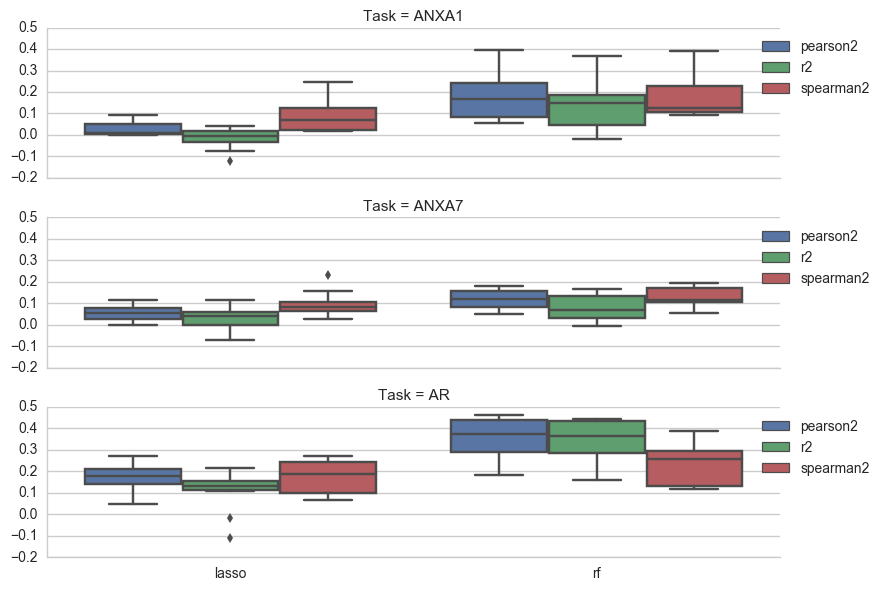

In [241]:
tasks = performance.sample_tasks(d_score, random_state=None, limit=3)
grid, d_viz = performance.plot_scores(d_score, metrics=None, tasks=tasks, figaspect=4, legend_margin=(1.14, 1))